# Author : Alexandre Gerzewski Da Silva
## Email  : alexandre19923@gmail.com
## GitHub : AlexandreG1998

In [4]:
import pandas as pd
import random
import numpy as np
import ta as ta
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout,LSTM, Conv2D, Flatten, MaxPooling2D
from keras.utils import np_utils
from matplotlib import pyplot as plt

from statsmodels.tsa.stattools import adfuller
from keras.utils.vis_utils import plot_model
import pydot
from keras.models import model_from_json
import graphviz
from tensorflow import keras
from time import time
from tensorflow.python.keras.callbacks import TensorBoard
import pandas_datareader
from pandas_datareader import data

import tensorflow.contrib.keras
from tensorflow.contrib.keras import models
from tensorflow.contrib.keras import activations

from tensorflow.contrib.keras import callbacks
from tensorflow.contrib.keras import layers
from tensorflow.contrib.keras import metrics


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import sklearn.svm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from arch import arch_model
import quandl
from statsmodels.tsa.api import VAR, DynamicVAR
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans

In [5]:
# Function to get OBV indicator, the ta version don't work as expected.
def OBV(close,volume):
    obv = volume
    obv = np.where(close > close.shift(), volume + obv.shift(),obv.shift() - volume)
    return(obv)

In [6]:
# Function to get a SVR model
#Dataset = Data used in nodel, it's a aytoregressive process so it will split in dependent and independent variables
# timestep = Number of previus observations 
#yhed = Target, the variable in x periods ahed
#cut_ = To avoid overfitting in final model it will be used just x percent of total dataset

def get_SVR (dataset = None, timestep = 30, yahed = 1, cut_ = 0.3):
    dataset = pd.DataFrame(dataset)
    dataset.columns = ["X"]
    for i in range(1,timestep):
        nome = "X."+str(i)
        dataset[nome] = dataset["X"].shift()
    dataset = dataset.dropna()
    Y = dataset["X"].shift(-yahed)
    cut = int(cut_ * len(dataset))
    train_x = dataset[:cut].values
    train_y = Y[:cut].values
    model = sklearn.svm.SVR()
    model.fit(train_x,train_y)
    return(model)

In [7]:
#Import Dataset of H1 EURUSD
dataset = pd.read_csv("eurusdh1.csv", sep=';')
dataset = dataset.set_index("Data")
dataset = dataset.dropna()
dataset.head()

,Open,High,Low,Close,Tickvol,Volume
Data,,,,,,
2002.03.31 17:00,0.8688,0.8690,0.8686,0.8688,30,19
2002.03.31 18:00,0.8689,0.8699,0.8687,0.8693,45,56
2002.03.31 19:00,0.8692,0.8707,0.8692,0.8706,67,43
2002.03.31 20:00,0.8707,0.8707,0.8705,0.8705,42,25
2002.03.31 21:00,0.8708,0.8711,0.8706,0.8709,32,75


In [8]:
# Prepare Dataset:

dataset_ = dataset

dataset_["Daily Return"] = ((dataset_["Close"]/dataset_["Close"].shift())-1) * 100
dataset_["Y Return"] = ((dataset_["Close"]/dataset_["Close"].shift(-5))-1) * -100
dataset_["Range"] = ((dataset_["High"]/dataset_["Low"])-1 ) * 100
dataset_["Body"] = np.where(dataset_["Range"] != 0, 
                         abs((dataset_["Close"]-dataset_["Open"])/(dataset_["High"]-dataset_["Low"]) * 100),0)
dataset_["OBV"] = OBV(dataset_["Close"], dataset_["Volume"])
dataset_["m20"] = dataset_["Close"].rolling(20).mean()
dataset_["m200"] = dataset_["Close"].rolling(200).mean()
dataset_["std20"] = dataset_["Close"].rolling(20).std()

dataset_["SB20"] = dataset_["m20"] + (dataset_["std20"] * 2)
dataset_["IB20"] = dataset_["m20"] - (dataset_["std20"] * 2)
dataset_["Bp"] = ((dataset_["SB20"] - dataset_["IB20"])/ dataset_["m20"]) * 100
dataset_["RSL"] = ((dataset_["Close"]/dataset_["m20"])-1) * 100
dataset_['RSL 200'] = ((dataset_["Close"]/dataset_["m200"])-1) * 100

dataset_["m20 - m200"] =  ((dataset_["m20"]/dataset_["m200"])-1) * 100
dataset_["Return m20"] = ((dataset_["m20"]/dataset_["m20"].shift())-1) * 100
dataset_["Return m200"] = ((dataset_["m200"]/dataset_["m200"].shift())-1) * 100
dataset_["Return STD"] = dataset_["Daily Return"].rolling(106).std()

dataset_["Squeeze"] = np.where(dataset_["Close"] > dataset_["SB20"],1,np.where(dataset_["Close"] < dataset_["IB20"],-1,0))

dataset_["Trend"] = np.where((dataset_["Daily Return"] > 0) & (dataset_["RSL"] > 0) & 
                          (dataset_["m20 - m200"] > 0) & (dataset_["Return m20"] > 0) & (dataset_["Return m200"] > 0),1,
                         np.where((dataset_["Daily Return"] < 0) & (dataset_["RSL"] < 0) & 
                          (dataset_["m20 - m200"] < 0) & (dataset_["Return m20"] < 0) & (dataset_["Return m200"] < 0),-1,0))


dataset_ = dataset_.dropna()
dataset_ = dataset_.drop("m20", axis=1)
dataset_ = dataset_.drop("m200", axis=1)
dataset_ = dataset_.drop("SB20", axis=1)
dataset_ = dataset_.drop("IB20", axis=1)
dataset_ = dataset_.drop("std20", axis=1)

dataset_.head()

,Open,High,Low,Close,Tickvol,Volume,Daily Return,Y Return,Range,Body,OBV,Bp,RSL,RSL 200,m20 - m200,Return m20,Return m200,Return STD,Squeeze,Trend
Data,,,,,,,,,,,,,,,,,,,,
2002.04.11 09:00,0.8808,0.8822,0.8803,0.8811,934,1763,0.022704,-0.045418,0.215836,15.789474,4369.0,0.560608,0.326222,0.553897,0.226934,0.017652,0.007019,0.088138,1,1
2002.04.11 10:00,0.8813,0.8822,0.8797,0.8806,809,907,-0.056747,0.011355,0.284188,28.000000,856.0,0.609053,0.254450,0.490356,0.235307,0.014802,0.006448,0.088136,0,0
2002.04.11 11:00,0.8807,0.8823,0.8807,0.8818,493,511,0.136271,-0.261512,0.181674,68.750000,1418.0,0.700919,0.369928,0.620864,0.250012,0.021062,0.006390,0.089006,1,1
2002.04.11 12:00,0.8820,0.8823,0.8804,0.8804,364,253,-0.158766,-0.068197,0.215811,84.210526,258.0,0.722525,0.196888,0.455438,0.258042,0.013659,0.005648,0.090442,0,0
2002.04.11 13:00,0.8804,0.8812,0.8801,0.8807,176,185,0.034075,-0.182004,0.124986,27.272727,438.0,0.746958,0.215634,0.484051,0.267840,0.015364,0.005591,0.090470,0,1


In [9]:
# Get SVR :
svm_STD_returns1 = get_SVR(dataset_.iloc[:,17:18].values)
svm_STD_returns2 = get_SVR(dataset_.iloc[:,17:18].values, yahed=2)
svm_STD_returns3 = get_SVR(dataset_.iloc[:,17:18].values, yahed=3)
svm_STD_returns4 = get_SVR(dataset_.iloc[:,17:18].values, yahed=4)
svm_STD_returns5 = get_SVR(dataset_.iloc[:,17:18].values, yahed=5)

In [10]:
# Get sequence data and forecast next STD of returns:

for i in range(1,30):
    nome = None
    nome = "RetornoL."+str(i)
    dataset_[nome] = dataset_["Daily Return"].shift(i)
for i in range(1,30):
    nome = None
    nome = "RangeL."+str(i)
    dataset_[nome] = dataset_["Range"].shift(i)
for i in range(1,30):
    nome = None
    nome = "BodyL."+str(i)
    dataset_[nome] = dataset_["Body"].shift(i)
for i in range(1,30):
    nome = None
    nome = "OBVL."+str(i)
    dataset_[nome] = dataset_["OBV"].shift(i)
    
    nome = "BpL."+str(i)
for i in range(1,30):
    nome = None
    dataset_[nome] = dataset_["Bp"].shift(i)
    
for i in range(1,30):
    nome = None
    nome = "RSL20L."+str(i)
    dataset_[nome] = dataset_["RSL"].shift(i)
for i in range(1,30):
    nome = None
    nome = "RSL200L."+str(i)
    dataset_[nome] = dataset_["RSL 200"].shift(i)
    
for i in range(1,30):
    nome = None
    nome = "TrendL."+str(i)
    dataset_[nome] = dataset_["Trend"].shift(i)
    
for i in range(1,30):
    nome = None
    nome = "Return STDL."+str(i)
    dataset_[nome] = dataset_["Return STD"].shift(i)

    
dataset_ = dataset_.dropna()



preverSTD =dataset_.iloc[:,17:18]


for i in range(1,30):
    nome = None
    nome = "Return STDL."+str(i)
    preverSTD[nome] = dataset_[nome]


dataset_["STD y1"] = svm_STD_returns1.predict(preverSTD.values)
dataset_["STD y2"] = svm_STD_returns2.predict(preverSTD.values)
dataset_["STD y3"] = svm_STD_returns3.predict(preverSTD.values)
dataset_["STD y4"] = svm_STD_returns4.predict(preverSTD.values)
dataset_["STD y5"] = svm_STD_returns5.predict(preverSTD.values)


In [11]:
dataset_.head()

,Open,High,Low,Close,Tickvol,Volume,Daily Return,Y Return,Range,Body,...,Return STDL.25,Return STDL.26,Return STDL.27,Return STDL.28,Return STDL.29,STD y1,STD y2,STD y3,STD y4,STD y5
Data,,,,,,,,,,,,,,,,,,,,,
2002.04.12 15:00,0.8774,0.8776,0.8768,0.8769,46,315,-0.045594,0.182129,0.091241,62.500000,...,0.090470,0.090442,0.089006,0.088136,0.088138,0.135432,0.135432,0.135432,0.135432,0.135432
2002.04.14 17:00,0.8770,0.8772,0.8770,0.8772,3,5,0.034211,0.238826,0.022805,100.000000,...,0.090470,0.090470,0.090442,0.089006,0.088136,0.135432,0.135432,0.135432,0.135432,0.135432
2002.04.14 18:00,0.8773,0.8775,0.8772,0.8775,45,105,0.034200,0.193358,0.034200,66.666667,...,0.090430,0.090470,0.090470,0.090442,0.089006,0.135432,0.135432,0.135432,0.135432,0.135432
2002.04.14 19:00,0.8776,0.8782,0.8775,0.8777,68,53,0.022792,0.147895,0.079772,14.285714,...,0.091321,0.090430,0.090470,0.090470,0.090442,0.135432,0.135432,0.135432,0.135432,0.135432
2002.04.14 20:00,0.8776,0.8786,0.8774,0.8782,37,110,0.056967,0.125100,0.136768,50.000000,...,0.091350,0.091321,0.090430,0.090470,0.090470,0.135432,0.135432,0.135432,0.135432,0.135432


In [12]:
# Delete the no squeeze rows
backup = dataset_
df = dataset_.drop(dataset_[dataset_["Squeeze"] == 0].index,  inplace=True)
dataset_.iloc[:,6:].head()
df = dataset_.iloc[:,6:]

In [13]:
df.head()

,Daily Return,Y Return,Range,Body,OBV,Bp,RSL,RSL 200,m20 - m200,Return m20,...,Return STDL.25,Return STDL.26,Return STDL.27,Return STDL.28,Return STDL.29,STD y1,STD y2,STD y3,STD y4,STD y5
Data,,,,,,,,,,,,,,,,,,,,,
2002.04.14 22:00,0.091064,-0.034130,0.079672,100.0,78.0,0.341804,0.191998,0.271690,0.079540,0.004558,...,0.091672,0.091672,0.091350,0.091321,0.090430,0.135432,0.135432,0.135432,0.135432,0.135432
2002.04.14 23:00,-0.011373,-0.045517,0.045506,25.0,-61.0,0.351140,0.179462,0.259086,0.079482,0.001139,...,0.090819,0.091672,0.091672,0.091350,0.091321,0.135432,0.135432,0.135432,0.135432,0.135432
2002.04.16 09:00,0.227635,-0.090930,0.341375,60.0,3357.0,0.351519,0.293843,0.395494,0.101353,0.013099,...,0.082114,0.082106,0.082191,0.081795,0.082312,0.135432,0.135432,0.135432,0.135432,0.135432
2002.04.16 10:00,0.022712,-0.125043,0.090878,0.0,3535.0,0.449969,0.299486,0.417036,0.117199,0.017084,...,0.081884,0.082114,0.082106,0.082191,0.081795,0.135432,0.135432,0.135432,0.135432,0.135432
2002.04.17 02:00,0.203943,0.079087,0.283479,80.0,2056.0,0.679624,0.456621,0.812978,0.354738,0.038066,...,0.081533,0.081976,0.082214,0.082207,0.081966,0.135432,0.135432,0.135432,0.135432,0.135432


In [14]:
# Prepare dataset for input in ANN

Y = df.iloc[:,1:2]
df = df.drop("Y Return", axis=1)

Yc = np.where(Y["Y Return"] > 0 ,1,0)

# Use MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))



cut = int(df.shape[0] * 0.7)

x_train = df[:cut].values
y_train = Yc[:cut]

x_test = df[cut:].values
y_test = df[cut:]

# Slip in train and test dataset
x_train_scaled = sc.fit_transform(x_train)
x_test_scaled = sc.transform(x_test)

#Use full dataset for final test
df_scaled = sc.transform(df.values)

In [15]:
model = Sequential()
model.add(Dense(units=251, input_dim = x_train_scaled.shape[1], activation="relu"))
model.add(Dense(units=128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units=32, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = "sigmoid"))

model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics=["acc"])

history = model.fit(x_train_scaled, y_train, batch_size=1000, epochs=100)

Epoch 1/100
8691/8691 [==============================] - 4s 414us/step - loss: 0.6992 - acc: 0.4984
Epoch 2/100
8691/8691 [==============================] - 4s 407us/step - loss: 0.6938 - acc: 0.5097
Epoch 3/100
8691/8691 [==============================] - 4s 485us/step - loss: 0.6938 - acc: 0.5066
Epoch 4/100
8691/8691 [==============================] - 2s 221us/step - loss: 0.6926 - acc: 0.5161
Epoch 5/100
8691/8691 [==============================] - 2s 208us/step - loss: 0.6923 - acc: 0.5144
Epoch 6/100
8691/8691 [==============================] - 2s 214us/step - loss: 0.6934 - acc: 0.5101
Epoch 7/100
8691/8691 [==============================] - 2s 212us/step - loss: 0.6930 - acc: 0.5078
Epoch 8/100
8691/8691 [==============================] - 2s 210us/step - loss: 0.6922 - acc: 0.5195
Epoch 9/100
8691/8691 [==============================] - 2s 226us/step - loss: 0.6929 - acc: 0.5082 0s - loss: 0.6931 - acc: 0.5
Epoch 10/100
8691/8691 [==============================] - 2s 231us/step

8691/8691 [==============================] - 2s 226us/step - loss: 0.6203 - acc: 0.6392
Epoch 82/100
8691/8691 [==============================] - 2s 189us/step - loss: 0.6228 - acc: 0.6380
Epoch 83/100
8691/8691 [==============================] - 2s 226us/step - loss: 0.6183 - acc: 0.6430
Epoch 84/100
8691/8691 [==============================] - 2s 197us/step - loss: 0.6142 - acc: 0.6420
Epoch 85/100
8691/8691 [==============================] - 2s 196us/step - loss: 0.6125 - acc: 0.6568 0s - loss: 0.6110 - acc: 0.
Epoch 86/100
8691/8691 [==============================] - 2s 190us/step - loss: 0.6082 - acc: 0.6452
Epoch 87/100
8691/8691 [==============================] - 2s 193us/step - loss: 0.6029 - acc: 0.6610
Epoch 88/100
8691/8691 [==============================] - 2s 200us/step - loss: 0.6102 - acc: 0.6537
Epoch 89/100
8691/8691 [==============================] - 2s 193us/step - loss: 0.6032 - acc: 0.6571
Epoch 90/100
8691/8691 [==============================] - 2s 203us/step - lo

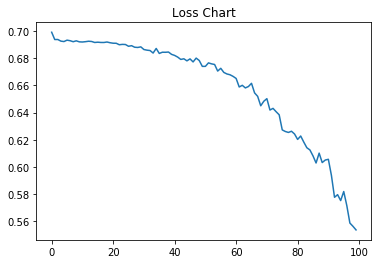

In [16]:
plt.plot(history.history["loss"])
plt.title("Loss Chart")
plt.show()

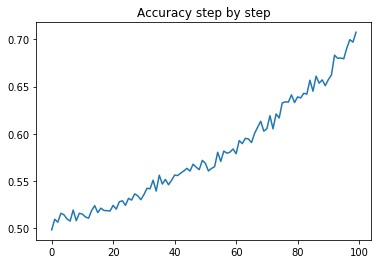

In [17]:
plt.plot(history.history["acc"])
plt.title("Accuracy step by step")
plt.show()

In [24]:
Y["Previsto"] = model.predict(df_scaled)
#Get the class by quartile 
Y["Classe"] = np.where(Y["Previsto"] <= np.percentile(Y["Previsto"][:cut].values,q=10 ),1,
                       np.where((Y["Previsto"] <= np.percentile(Y["Previsto"][:cut].values,q=20))&
                                (Y["Previsto"] > np.percentile(Y["Previsto"][:cut].values,q=10)),2,
                    
                        np.where((Y["Previsto"] <= np.percentile(Y["Previsto"][:cut].values,q=30))&
                                (Y["Previsto"] > np.percentile(Y["Previsto"][:cut].values,q=20)),3,
                        
                        np.where((Y["Previsto"] <= np.percentile(Y["Previsto"][:cut].values,q=40))&
                                (Y["Previsto"] > np.percentile(Y["Previsto"][:cut].values,q=30)),4,
                                
                        np.where((Y["Previsto"] <= np.percentile(Y["Previsto"][:cut].values,q=50))&
                                (Y["Previsto"] > np.percentile(Y["Previsto"][:cut].values,q=40)),5,
                       
                        np.where((Y["Previsto"] <= np.percentile(Y["Previsto"][:cut].values,q=60))&
                                (Y["Previsto"] > np.percentile(Y["Previsto"][:cut].values,q=50)),6,
                                
                        np.where((Y["Previsto"] <= np.percentile(Y["Previsto"][:cut].values,q=70))&
                                (Y["Previsto"] > np.percentile(Y["Previsto"][:cut].values,q=60)),7,
                                
                        np.where((Y["Previsto"] <= np.percentile(Y["Previsto"][:cut].values,q=80))&
                                (Y["Previsto"] > np.percentile(Y["Previsto"][:cut].values,q=70)),8,
                                
                        np.where((Y["Previsto"] <= np.percentile(Y["Previsto"][:cut].values,q=90))&
                                (Y["Previsto"] > np.percentile(Y["Previsto"][:cut].values,q=80)),9,10)))))))))


Y["Pos/Neg"] = np.where(Y["Y Return"] > 0,1,0 )
#Use to backtest the last 30% of dataset
Y[:cut].groupby(["Classe","Pos/Neg"])["Y Return"].sum()


Classe  Pos/Neg
1       0         -228.976961
        1            2.583872
2       0         -146.820038
        1           30.934796
3       0         -114.918653
        1           53.893365
4       0          -98.539707
        1           69.184208
5       0          -79.305967
        1           94.715896
6       0          -67.077800
        1          106.672532
7       0          -64.351028
        1          111.056870
8       0          -49.745858
        1          134.689438
9       0          -43.126613
        1          149.659271
10      0          -16.116287
        1          226.660973
Name: Y Return, dtype: float64

In [26]:
Y["Squeeze"] = df["Squeeze"].values
Y["Sinal"] = np.where(Y["Classe"] == 10, 1,np.where(Y["Classe"] == 1,-1,0))

Y["Pontos"] = Y["Y Return"] * Y["Sinal"]

Y["Machine Learning Squeeze"] = Y["Pontos"].cumsum()

Y_ = Y[cut:]
Y_["Machine Learning Squeeze"] = Y_["Pontos"].cumsum()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [27]:
Y_["Gain"] = np.where(Y_["Pontos"] > 0,1,0)
Y_['Points of Classical Squeeze'] = Y_['Y Return'] * Y_['Squeeze']
Y_['Cumulative Squeeze'] = Y_['Points of Classical Squeeze'].cumsum()
Y_['Squeeze gain'] = np.where(Y_['Points of Classical Squeeze']>0,1,0)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

In [28]:
print("Hit rate Classical Squeeze  :", 100 *( (sum(Y_['Squeeze gain'])) / (Y_.shape[0])) )
print("Hit rate Squeeze with Machine Learning  :", 100 *( (sum(Y_["Gain"])) / (sum(abs(Y_['Sinal'])))) )

Hit rate Classical Squeeze  : 48.644295302013425
Hit rate Squeeze with Machine Learning  : 49.91023339317774


In [29]:
Y_ = Y_.reset_index()

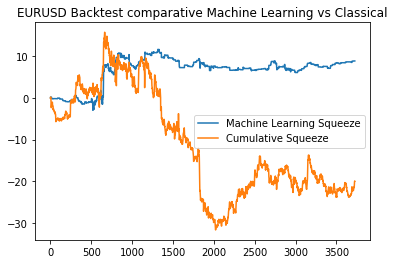

In [30]:
plt.plot(Y_["Machine Learning Squeeze"])
plt.plot(Y_['Cumulative Squeeze'])
plt.legend()
plt.title("EURUSD Backtest comparative Machine Learning vs Classical")
plt.show()

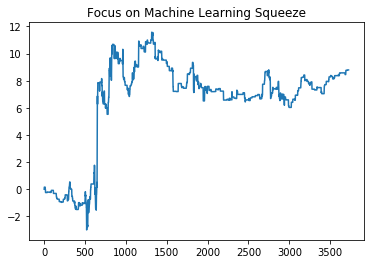

In [31]:
plt.plot(Y_["Machine Learning Squeeze"])
plt.title('Focus on Machine Learning Squeeze')
plt.show()